***Get headlines from Heroku:***

In [1257]:
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
sns.set_style('white')
from IPython.display import display


db_url = os.environ['DATABASE_URL']
headlines = pd.read_sql_query('SELECT index, headline AS text, pub, url FROM headlines;', create_engine(db_url), index_col='index')
print(f'{len(headlines):,} raw headlines')
headlines['text'].sample(5, random_state=42).head().values.tolist()

# Deduplication:
print(f'{len(headlines) - len(headlines.drop_duplicates()):,} duplicates')
headlines.drop_duplicates(inplace=True)
print(headlines.shape)
headlines.reset_index(inplace=True, drop=True)
headlines.head()

2,859 raw headlines
0 duplicates
(2859, 3)


,text,pub,url
0,"As China Plans Big Concessions on Trade, Some ...",nyt,https://www.nytimes.com/2018/05/17/us/politics...
1,"China, Signaling Thaw With U.S. Over Trade, Ap...",nyt,https://www.nytimes.com/2018/05/17/business/de...
2,Qatar-Linked Firm Nears Deal to Bail Out Kushn...,nyt,https://www.nytimes.com/2018/05/17/nyregion/ku...
3,"Filing Shows Trump Paid Cohen, Who Paid Stormy...",nyt,https://www.nytimes.com/2018/05/16/us/politics...
4,"Trump Rants, Calling Some Unauthorized Immigra...",nyt,https://www.nytimes.com/2018/05/16/us/politics...


In [1258]:
headlines['text'].sample(5, random_state=0).values.tolist()

['Trump’s next round of trade limits could hurt the tech industry he wants to help',
 'Mimi Swartz: Things Have Changed Since Sandy Hook',
 'Dusting Off an Art Deco Feminist Treasure',
 'Why bring politics into Armed Forces Day? Because this year, our servicemen and women deserve it',
 'Meet the donors pouring millions into the 2018 elections']

Do different sources have different vocabularies?

Some patterns:

* Source:paraphrase|quote, e.g., "Ex-FBI official: Trump was right to fire Comey"
    * Can we extract quotes/paraphrases and their source?
* State abbreviations, e.g., "Md." for Maryland
* Lots of long apposatives, e.g., "Md. Democratic candidate for governor Valerie Ervin ..."

***Data cleaning:***

In [1259]:
# Drop headlines about TV shows, e.g., "Hannity - Monday, May 16"
display(headlines.loc[headlines.text.str.contains(r'\S+\s* [-–—] \S+\s*, May .+')].sample(5))
headlines = headlines.loc[~headlines.text.str.contains(r'\S+\s* [-–—] \S+\s*, May .+')]
headlines.shape

,text,pub,url
2722,"Special Report With Bret Baier - Monday, May 21",fox,//video.foxnews.com/v/5787858151001/?playlist_...
2747,"The Story w/ Martha MacCallum - Monday, May 21",fox,//video.foxnews.com/v/5787865611001/?playlist_...
590,"Fox News @ Night - Thursday, May 17",fox,//video.foxnews.com/v/5786474684001/?playlist_...
591,"The Ingraham Angle - Thursday, May 17",fox,//video.foxnews.com/v/5786457745001/?playlist_...
1768,"The Next Revolution w/Steve Hilton – Sunday, M...",fox,//video.foxnews.com/v/5787483762001/?playlist_...


(2828, 3)

In [1260]:
# Strip a common time pattern on video headlines
time_pat = f'(\s\d+:\d+ (PM|AM) \w+[{string.punctuation}]*\s*)'
display(headlines[headlines.text.str.contains(time_pat)].sample(5))
headlines['text'] = headlines['text'].str.replace(pat, '')
strip_pat(time_pat)
headlines.drop_duplicates(inplace=True)
headlines.shape

C:\Anaconda3\envs\media\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


,text,pub,url
2026,"Monarchs in My Garden, at Last 5:45 AM ET",nyt,https://www.nytimes.com/2018/05/21/opinion/pol...
2590,Dozens Die in Karachi from Relentless Heat 5:2...,nyt,https://www.nytimes.com/2018/05/21/world/karac...
2183,"Monarchs in My Garden, at Last 10:13 AM ET",nyt,https://www.nytimes.com/2018/05/21/opinion/pol...
2833,Dozens Die in Karachi From Relentless Heat 12:...,nyt,https://www.nytimes.com/2018/05/21/world/karac...
2506,How to Vote in Venezuela’s (Non) Election 3:20...,nyt,https://www.nytimes.com/2018/05/21/opinion/ven...


(2770, 3)

In [1261]:
# This could interfere with pos_tag
# Remove punctuation, except for the hyphen
# headlines['text'] = headlines['text'].str.replace(f'[{string.punctuation.replace("-", "")}]' , '')
# headlines.drop_duplicates(inplace=True)
headlines.shape

(2770, 3)

In [1262]:
# Standardize quotation marks:
headlines['text'] = headlines['text'].str.replace(r'[”’\'"“‘]', '\'')
headlines.drop_duplicates(inplace=True)
headlines.shape

(2768, 3)

In [1263]:
display(headlines[headlines.text.str.contains('»')])
headlines['text'] = headlines['text'].str.replace('»', '')
headlines.drop_duplicates(inplace=True)
headlines.shape

,text,pub,url
776,Follow us on Twitter »,nyt,https://twitter.com/nytopinion


(2768, 3)

In [1264]:
display(headlines[headlines.text.str.contains('`')])
headlines = headlines[~headlines.text.str.contains('`')]

,text,pub,url
1329,`: Dusting Off an Art Deco Feminist Treasure,nyt,https://www.nytimes.com/2018/05/16/nyregion/du...


In [1265]:
display(headlines[headlines.text.str.contains('ツ')])
headlines = headlines[~headlines.text.str.contains('ツ')]

,text,pub,url
1160,'Just saying ¯\_(ツ)_/¯' — BBC Three compares r...,wapo,https://www.washingtonpost.com/news/worldviews...


In [1266]:
display(headlines[headlines.text.str.contains('/')])
headlines = headlines[~headlines.text.str.contains('/')]

,text,pub,url
1285,Hits & Misses: 5/19/18,fox,//video.foxnews.com/v/5787182621001/


In [1267]:
display(headlines[headlines.text.str.contains('\*')])
headlines = headlines[~headlines.text.str.contains('\*')]

,text,pub,url
2805,"Not at the Game*: Courtside With Run TMC, Watc...",nyt,https://www.nytimes.com/2018/05/21/sports/gold...


In [1268]:
# Replace incorrectly-used hyphens with an m-dash
display(headlines[headlines.text.str.contains(' [-–] ')])
headlines['text'] = headlines.text.str.replace(' [-–] ', ' — ')
headlines.drop_duplicates(inplace=True)
headlines.shape

,text,pub,url
142,Lincoln vs. Obama - The incredible tale of two...,fox,http://www.foxnews.com/opinion/2018/05/16/tamm...
143,America - We must remember how to respectfully...,fox,http://www.foxnews.com/opinion/2018/05/17/cal-...
1005,GOP pours cash into bid to repeal California g...,fox,//www.foxnews.com/politics/2018/05/19/gop-pour...
1118,Royal caught lounging at wedding - and Twitter...,fox,http://www.foxnews.com/entertainment/2018/05/1...
2196,'Legends & Lies – Abraham Lincoln: The Campaign',fox,//video.foxnews.com/v/5787444706001/?playlist_...
2242,Jesus banned - School censors valedictorian's ...,fox,http://www.foxnews.com/opinion/2018/05/21/todd...
2326,Disgraced Dem Conyers endorsed son for his own...,fox,http://www.foxnews.com/politics/2018/05/21/dis...
2334,Disgraced Dem Conyers endorsed son for his own...,fox,//www.foxnews.com/politics/2018/05/21/disgrace...
2362,Disgraced Democrat forced out of House endorse...,fox,http://www.foxnews.com/politics/2018/05/21/dis...


(2764, 3)

In [1269]:
headlines['text'] = headlines.text.str.replace('\s+', ' ')
headlines.drop_duplicates(inplace=True)
headlines.shape

(2763, 3)

In [1270]:
headlines['text'] = headlines['text'].str.strip()
headlines.drop_duplicates(inplace=True)
headlines.shape

(2763, 3)

In [1271]:
set(re.sub(pattern=f'[{string.ascii_letters}\s\d]', repl='', string=' '.join(headlines.text)))

{'!',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 ':',
 ';',
 '=',
 '?',
 '|',
 'á',
 'í',
 '—'}

In [1272]:
# References to money
display(headlines[headlines.text.str.contains('\$')].sample(5))
headlines[headlines.text.str.contains('\$')].shape

,text,pub,url
1556,California man wins more than $6 million from ...,fox,//www.foxnews.com/us/2018/05/20/california-man...
1555,California man wins 4 lottery prizes worth $6M...,fox,http://www.foxnews.com/us/2018/05/20/californi...
2153,"Wrecked $250,000 Ferrari found without a driver",fox,http://video.foxnews.com/v/5787683904001/
739,Steven Tyler reveals he once hit on Cameron Di...,fox,http://www.foxnews.com/entertainment/2018/05/1...
98,"$800,000 Homes in Missouri, Georgia and Pennsy...",nyt,https://www.nytimes.com/2018/05/16/realestate/...


(43, 3)

In [1273]:
# Parentheticals
display(headlines[headlines.text.str.contains('\(')].sample(5).values)
headlines[headlines.text.str.contains('\(')].shape

array([["It's the 50th anniversary of the day Trump left college and (briefly) faced the draft",
        'wapo',
        'https://www.washingtonpost.com/news/retropolis/wp/2018/05/20/its-the-50th-anniversary-of-the-day-trump-left-college-and-nearly-had-to-go-to-war/'],
       ['Lawyers for Michael Cohen and Stormy Daniels Sling More (Legal) Mud',
        'nyt',
        'https://www.nytimes.com/2018/05/18/nyregion/michael-cohen-stormy-daniels-legal-fight.html'],
       ['Bitcoin Goes Mainstream (in a Hilton Ballroom)', 'nyt',
        'https://www.nytimes.com/2018/05/18/technology/consensus-bitcoin-conference-photos.html'],
       ['We dropped $18,000 worth of phones, and these are the toughest (and weakest)',
        'fox',
        '//www.foxnews.com/tech/2018/05/21/dropped-18000-worth-phones-and-these-are-toughest-and-weakest.html'],
       ['Step-by-step | How to decorate a layer cake (like a royal)',
        'wapo',
        'http://www.washingtonpost.com/graphics/2018/voraciously/amp

(21, 3)

In [1274]:
# Excalamations
display(headlines[headlines.text.str.contains('!')].sample(5).values)
headlines[headlines.text.str.contains('!')].shape

array([['Smug Seattle to mom and pop landlords: Criminals are welcome! Your rights not so much',
        'fox',
        '//www.foxnews.com/opinion/2018/05/21/smug-seattle-to-mom-and-pop-landlords-criminals-are-welcome-your-rights-not-so-much.html'],
       ['Here comes the bride! Meghan, Harry arrive', 'fox',
        'http://www.foxnews.com/entertainment/2018/05/19/meghan-markle-prince-harrys-royal-wedding-guests-begin-arriving-couples-new-titles-revealed.html'],
       ["15-foot great white shark shocks scuba divers above Florida Keys shipwreck: 'Get on the boat!'",
        'fox',
        'http://www.foxnews.com/science/2018/05/21/15-foot-great-white-shark-shocks-scuba-divers-above-florida-keys-shipwreck-get-on-boat.html'],
       ["Trump Says Russia Inquiry's Overreach Is a Scandal 'Bigger Than Watergate!'",
        'nyt',
        'https://www.nytimes.com/2018/05/17/us/politics/trump-watergate-russia-investigation.html'],
       ["'My next call is to ICE!': Man's rant against workers

(12, 3)

***Visualizations:***

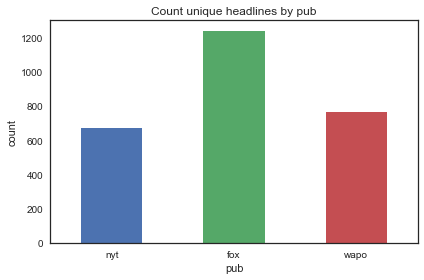

In [1276]:
ax = headlines.groupby('pub').apply(lambda grp: grp['text'].unique().shape[0])[['nyt', 'fox', 'wapo']].plot(kind='bar', title='Count unique headlines by pub')
ax.set(ylabel='count')
[tick.set_rotation(0) for tick in ax.get_xticklabels()]
plt.tight_layout()

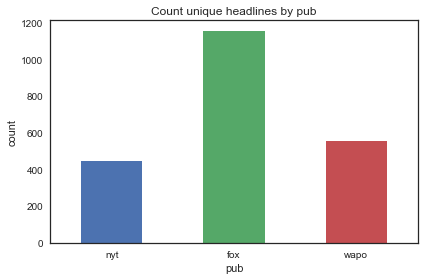

In [1277]:
ax = headlines.groupby('pub').apply(lambda grp: grp['url'].unique().shape[0])[['nyt', 'fox', 'wapo']].plot(kind='bar', title='Count unique headlines by pub')
ax.set(ylabel='count')
[tick.set_rotation(0) for tick in ax.get_xticklabels()]
plt.tight_layout()

In [1279]:
ct_headlines = headlines.groupby('pub').apply(lambda grp: grp['text'].unique().shape[0])
ct_urls = headlines.groupby('pub').apply(lambda grp: grp['url'].unique().shape[0])
ct_headlines / ct_urls

pub
fox     1.073657
nyt     1.506726
wapo    1.379061
dtype: float64

Does Fox have this many real headlines, or do they just swap out headlines more often? Interestingly, Fox actually has _fewer_ headlines per URL, suggesting that WaPo and NYT change headlines mid-publication more often.

In [ ]:
ax = headlines['pub'].value_counts()[['nyt', 'fox', 'wapo']].plot(kind='bar', title='Count unique headlines by pub')
ax.set(ylabel='count')
[tick.set_rotation(0) for tick in ax.get_xticklabels()]
plt.tight_layout()

Headline length:

WaPo tends to have longer headlines, but only because they have more words (rather than using longer words).

In [1101]:
headlines['len_words'] = headlines['text'].str.split('\s').apply(len)
headlines['len_chars'] = headlines['text'].apply(len)
headlines['len_avg_word'] = headlines['text'].str.replace(f'[{string.punctuation}]' , '').str.split('\s').apply(lambda l: sum(map(len, l)) / len(l))

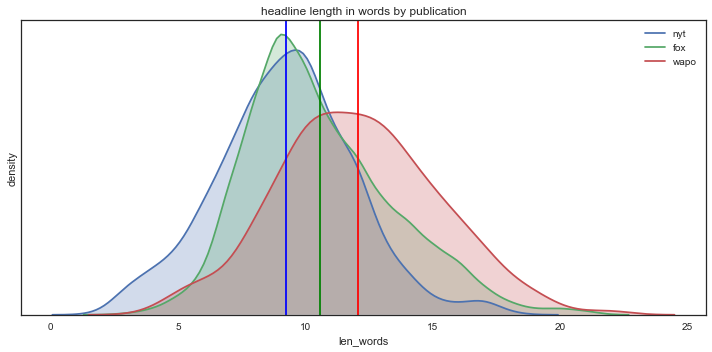

In [1215]:
sns.distplot(headlines.loc[headlines['pub']=='nyt', 'len_words'], label='nyt', hist=False, kde_kws={'shade': True})
sns.distplot(headlines.loc[headlines['pub']=='fox', 'len_words'], label='fox', hist=False, kde_kws={'shade': True})
ax = sns.distplot(headlines.loc[headlines['pub']=='wapo', 'len_words'], label='wapo', hist=False, kde_kws={'shade': True})

ax.axvline(headlines.loc[headlines['pub']=='nyt', 'len_words'].mean(), color='blue')
ax.axvline(headlines.loc[headlines['pub']=='fox', 'len_words'].mean(), color='green')
ax.axvline(headlines.loc[headlines['pub']=='wapo', 'len_words'].mean(), color='red')

ax.legend()
ax.axes.get_yaxis().set_ticks([])
ax.set(title='headline length in words by publication', ylabel='density')
ax.figure.set_size_inches((10,5))
plt.tight_layout()

In [1108]:
print('Examples of headlines with many words:')
print(headlines.loc[headlines['len_words'] > 15, 'text'].sample(5).values)

print()
print('Examples of headlines with average words:')
print(headlines.loc[headlines['len_words'] == 10, 'text'].sample(5).head().values)

print()
print('Examples of headlines with few words:')
print(headlines.loc[headlines['len_words'] < 5, 'text'].sample(5).head().values)

Examples of headlines with many words:
['Woman who helped concoct fake story about Muslim men groping women at German bar found dead'
 'Two sons of Rev. Moon have split from his church — and their followers are armed'
 "Critic's Notebook: On That 'Barry' Finale and Why Some Shows Are So Good, They Need to End"
 "Once Hated by U.S. and Tied to Iran, Is Sadr Now 'Face of Reform' in Iraq?"
 'The truth is out there: The real story of Area 51 may be weirder than the science fiction']

Examples of headlines with average words:
["A father's secret wish for mothers that get little credit"
 'D.C. United shakes Earthquakes with early goals in 3-1 victory'
 'Judge in Stanford rape case is subject of recall vote'
 'Bernard Lewis, Influential Scholar of Islam, Is Dead at 101'
 "Texans defensive end J.J. Watt to pay for victims' funerals"]

Examples of headlines with few words:
['Mortgage Calculator' "Venezuela's sham election" 'Death of a Biohacker'
 'Trump demands DOJ probe' 'The Royal Wedding']


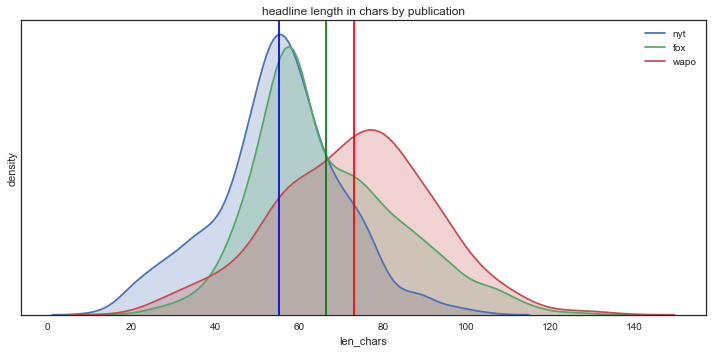

In [1103]:
sns.distplot(headlines.loc[headlines['pub']=='nyt', 'len_chars'], label='nyt', hist=False, kde_kws={'shade': True})
sns.distplot(headlines.loc[headlines['pub']=='fox', 'len_chars'], label='fox', hist=False, kde_kws={'shade': True})
ax = sns.distplot(headlines.loc[headlines['pub']=='wapo', 'len_chars'], label='wapo', hist=False, kde_kws={'shade': True})

ax.axvline(headlines.loc[headlines['pub']=='nyt', 'len_chars'].mean(), color='blue')
ax.axvline(headlines.loc[headlines['pub']=='fox', 'len_chars'].mean(), color='green')
ax.axvline(headlines.loc[headlines['pub']=='wapo', 'len_chars'].mean(), color='red')

ax.legend()
ax.axes.get_yaxis().set_ticks([])
ax.set(title='headline length in chars by publication', ylabel='density')
ax.figure.set_size_inches((10,5))
plt.tight_layout()

In [1109]:
print('Examples of headlines with many chars:')
print(headlines.loc[headlines['len_chars'] > 100, 'text'].sample(5).values)

print()
print('Examples of headlines with average chars:')
print(headlines.loc[headlines['len_chars'] == 65, 'text'].sample(5).head().values)

print()
print('Examples of headlines with few chars:')
print(headlines.loc[headlines['len_chars'] < 20, 'text'].sample(5).head().values)

Examples of headlines with many chars:
['MUST SEE: Nail salon worker jumps onto moving car to stop customer from leaving without paying her bill'
 "At Texas vigil, another school mourns another mass shooting: 'It is hope in the face of tragedy that brings us together today'"
 "HBO star Shannon Woodward makes shocking return to 'Westworld' after storming social media with anti-Trump insults"
 "Meghan Markle, Prince Harry's royal wedding: Groom arrives with brother Prince William, waves to crowds"
 'Cops focus on teen boy previously caught with Pennsylvania teacher in steamed-up car in murder investigation']

Examples of headlines with average chars:
["Don't let the Trump administration derail criminal-justice reform"
 'Heisman winner Manziel signs, will play with new team this summer'
 'Camping without the hassle: Rent the gear you need — even the car'
 'Loose Ends: The Only Houseplants You Can Be Trusted With: A Guide'
 'Trump will nominate the acting secretary to head Veterans Affairs

In [1113]:
headlines[headlines['len_chars'] == headlines['len_chars'].min()].values

array([['A.I. Is Hard', 'nyt', 3, 12, 2.6666666666666665]], dtype=object)

In [1112]:
headlines[headlines['len_chars'] == headlines['len_chars'].max()].values

array([['Prisons are allowing mothers to raise their babies behind bars. But is the radical experiment in parenting and punishment a good idea?',
        'wapo', 22, 134, 5.045454545454546]], dtype=object)

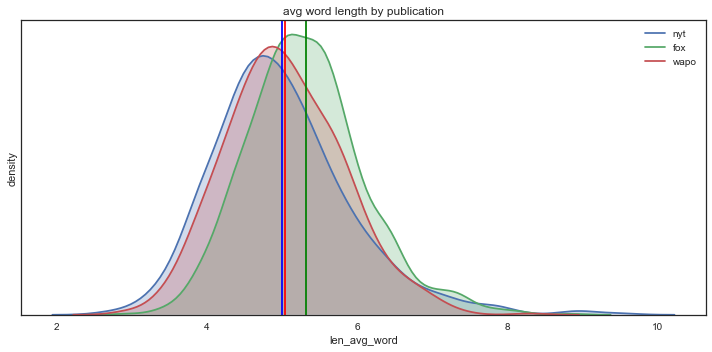

In [1104]:
sns.distplot(headlines.loc[headlines['pub']=='nyt', 'len_avg_word'], label='nyt', hist=False, kde_kws={'shade': True})
sns.distplot(headlines.loc[headlines['pub']=='fox', 'len_avg_word'], label='fox', hist=False, kde_kws={'shade': True})
ax = sns.distplot(headlines.loc[headlines['pub']=='wapo', 'len_avg_word'], label='wapo', hist=False, kde_kws={'shade': True})

ax.axvline(headlines.loc[headlines['pub']=='nyt', 'len_avg_word'].mean(), color='blue')
ax.axvline(headlines.loc[headlines['pub']=='fox', 'len_avg_word'].mean(), color='green')
ax.axvline(headlines.loc[headlines['pub']=='wapo', 'len_avg_word'].mean(), color='red')

ax.legend()
ax.axes.get_yaxis().set_ticks([])
ax.set(title='avg word length by publication', ylabel='density')
ax.figure.set_size_inches((10,5))
plt.tight_layout()

In [1114]:
print('Examples of headlines with long avg word length:')
print(headlines.loc[headlines['len_avg_word'] > 8, 'text'].sample(5).values)

print()
print('Examples of headlines with avg avg word length:')
print(headlines.loc[headlines['len_avg_word'] == 5, 'text'].sample(5).values)

print()
print('Examples of headlines with short avg word length:')
print(headlines.loc[headlines['len_avg_word'] < 4, 'text'].sample(5).head().values)

Examples of headlines with long avg word length:
['State regulators unveil nationwide crackdown on suspicious cryptocurrency investment schemes'
 'Progressive Democrats outperforming moderates in primaries'
 'Mortgage Calculator' 'Monarchy Meets African-American Experience'
 "Researchers answer long-running rumors surrounding Hitler's death"]

Examples of headlines with avg avg word length:
["Meghan Markle, Prince Harry marry at St. George's Chapel"
 'Trump pushes for prison reform bill'
 'Prince Charles Walks a Radiant Meghan Markle Down the Aisle'
 'T.J. Oshie, Braden Holtby carry Capitals to Game 7 against Lightning'
 'Fans at the Royal Wedding, and Their Accessories']

Examples of headlines with short avg word length:
['A Staten Island Man Found a Safe of Cash in His Backyard. Then Things Got Weird.'
 'Why the GOP needs someone — anyone — to challenge Trump in 2020'
 'Hawaii lava flow ramps up as new magma mixes with old'
 'Veteran: I had five hour wait at VA last week'
 'How a Dig

In [1117]:
print('Ten random headlines:')
headlines.sample(10, random_state=0)['text'].values.tolist()

Ten random headlines:


['Controversial armored police vehicle factory expands production to meet demand',
 'The Latest: Hawaii lava flow may cross highway within hours',
 'T.J. Oshie, Braden Holtby carry Capitals to Game 7 against Lightning',
 "Woman claims Mario Batali drugged, sexually assaulted her inside NYC restaurant's 'rape room'; NYPD investigating allegations",
 "'World's most expensive Witch Hunt': Trump lashes out at New York Times, Democrats",
 'What to Pack in Your New York City Survival Kit',
 'Venezuelan President Nicolás Maduro wins reelection amid charges of irregularities',
 'Lawmakers are nudging Twitter CEO Jack Dorsey to testify before Congress on privacy',
 'Baby hit by softball opening eyes, moving legs',
 'Crisis-weary Venezuelans are voting in election decried as a Maduro power grab']

***Play with NLTK and TextBlob:***

In [1193]:
from nltk import Text
from textblob import TextBlob

txt = Text('. '.join(headlines['text']).split())
display(txt)

blob = TextBlob('. '.join(headlines['text']))
blob[:10]

<Text: As China Plans Big Concessions on Trade, Some...>

TextBlob("As China P")

In [1221]:
txt.collocations()

Meghan Markle; Prince Harry; Meghan Markle,; school shooting; Prince
Harry's; Meghan Markle's; royal wedding; Markle, Prince; NBA
playoffs:; royal wedding.; high school; Texas school; White House; New
York; Naval Academy; Royal Wedding; Lightning-Capitals Game; North
Korea; Academy freshmen; school shooting.


In [1237]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
b
ex = headlines.text.sample(random_state=3).values[0]
print(ex)
tokenizer.tokenize(ex)

NOT REAL NEWS: False comments attributed to Zimbabwe leader


['NOT',
 'REAL',
 'NEWS',
 ':',
 'False',
 'comments',
 'attributed',
 'to',
 'Zimbabwe',
 'leader']

In [1241]:
# from https://www.nltk.org/book/ch02.html#wordlist-corpora
def unusual_words(text):
    text_vocab = set(w.lower() for w in text if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab - english_vocab
    return sorted(unusual)

pd.Series(unusual_words(txt)).sample(5, random_state=0)

1142          poses
1044            ohr
1000    negotiating
1121        planned
1212         reagan
dtype: object

In [1243]:
unusual_words(txt)

['abortions',
 'accents',
 'accounts',
 'accuses',
 'accusing',
 'aches',
 'achilles',
 'acosta',
 'activists',
 'adams',
 'addresses',
 'administering',
 'admits',
 'adolf',
 'adored',
 'ads',
 'adventures',
 'advisers',
 'advising',
 'advocates',
 'affairs',
 'affects',
 'afghanistan',
 'afghans',
 'ag',
 'agencies',
 'agrees',
 'airlifting',
 'airline',
 'airlines',
 'albies',
 'alek',
 'ali',
 'allegations',
 'alleged',
 'alleges',
 'alleging',
 'allowing',
 'allows',
 'alsobrooks',
 'amal',
 'americans',
 'amgen',
 'amtrak',
 'analyzing',
 'ancestors',
 'anchors',
 'andrei',
 'angaleena',
 'angeles',
 'angered',
 'announced',
 'announces',
 'answers',
 'antiabortion',
 'antonin',
 'ap',
 'apologizes',
 'app',
 'appearances',
 'appeared',
 'appoints',
 'approves',
 'apps',
 'arabia',
 'argentines',
 'argento',
 'argues',
 'arie',
 'arrested',
 'arrests',
 'arrivals',
 'arrived',
 'arrives',
 'artisans',
 'artists',
 'arts',
 'asia',
 'asked',
 'asks',
 'assassinated',
 'assaulted',

In [1246]:
print('abortions' in nltk.corpus.words.words())
print('abortion' in nltk.corpus.words.words())

False
True


In [1247]:
def content_fraction(text):
    stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in text if w.lower() not in stopwords]
    return len(content) / len(text)

content_fraction(txt)

0.7330637724338511

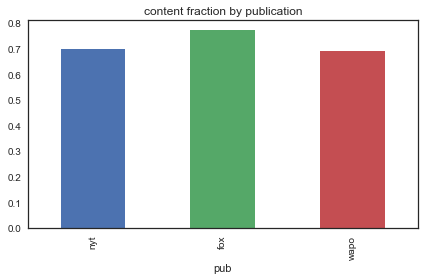

In [1253]:
headlines.groupby('pub').apply(lambda grp: content_fraction(Text(' '.join(grp['text']).split())))[['nyt', 'fox', 'wapo']].plot(kind='bar', title='content fraction by publication')
plt.tight_layout()

In [1238]:
from nltk import pos_tag

pos_tag(tokenizer.tokenize(ex))

[('NOT', 'NNP'),
 ('REAL', 'NNP'),
 ('NEWS', 'NNP'),
 (':', ':'),
 ('False', 'JJ'),
 ('comments', 'NNS'),
 ('attributed', 'VBD'),
 ('to', 'TO'),
 ('Zimbabwe', 'NNP'),
 ('leader', 'NN')]

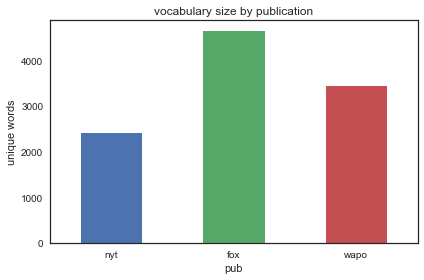

In [1216]:
vocab = headlines.groupby('pub').apply(lambda grp: len(set(' '.join(grp['text']).split())))[['nyt', 'fox', 'wapo']]
ax = vocab.plot(title='vocabulary size by publication', kind='bar')
[tick.set_rotation(0) for tick in ax.get_xticklabels()]
ax.set(ylabel='unique words')
plt.tight_layout()

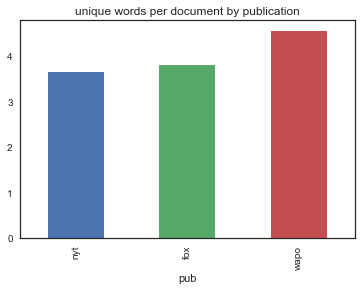

In [1254]:
(vocab / headlines.groupby('pub').count()['text'])[['nyt', 'fox', 'wapo']].plot(title='unique words per document by publication', kind='bar')

Fox has a larger overall vocabulary, but only because it publishes more headlines in general. WaPo has the most diverse vocabulary on a per-headline basis because they tend to use more words.

In [1133]:
txt.count('Trump')

245

In [1134]:
txt.count('Mueller')

31

In [1135]:
txt.count('America')

14

In [1142]:
txt.count('wedding')

93

In [1143]:
txt.count('the')

535

In [1144]:
txt.count('an')

42

In [1145]:
txt.count('a')

331

In [1146]:
txt.count('of')

469

In [1147]:
txt.count('by')

82

In [1148]:
txt.count('with')

173

In [1157]:
len(txt)

28194

In [1166]:
txt.similar('Trump')

his u.s. watch entire russia long alleged resume yanny likely gop's go
official football point surveilled 'westworld'


In [1176]:
txt.common_contexts(['Trump', 'Russia'])

the_inquiry


In [1177]:
txt.similar('Mueller')

russia mueller's fbi


In [1178]:
txt.common_contexts(['Mueller', 'Russia'])

the_probe


***Vectorize the headlines:***

In [798]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [1181]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.snowball import EnglishStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.tokenize import RegexpTokenizer
from nltk.tag import ???

from nltk.corpus import stopwords

analyzer_args = dict(        
    stop_words='english', 
    ngram_range=(2,2),
    max_df=1.0,
    min_df=1,
    max_features=None,
    binary=False,
    norm=None,
    use_idf=False,
    smooth_idf=False,
    sublinear_tf=False
)

tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
def custom_tokenizer(string):
    stop_words = set(stopwords.words('english'))
    tokens = tokenizer(string) 
    tokens = [w for w in tokens if not w in stop_words]
    return map(str, pos_tag(tokens, tagset='universal'))

def custom_analyzer(doc):
    stemmer = WordNetLemmatizer()
    analyzer = TfidfVectorizer(tokenizer=custom_tokenizer, **analyzer_args).build_analyzer()
    return (stemmer.lemmatize(w) for w in analyzer(doc))

vect = TfidfVectorizer(analyzer=custom_analyzer, tokenizer=custom_tokenizer, **analyzer_args)

tdmatrix = vect.fit_transform(headlines['text'])
tdmatrix = pd.DataFrame(tdmatrix.toarray(), columns=vect.get_feature_names(), index=headlines.index)
print(tdmatrix.shape)
print(tdmatrix.sum().sort_values(ascending=False).head(10))
tdmatrix.head()

SyntaxError: invalid syntax (<ipython-input-1181-4822f92aecd0>, line 16)

***Term counts:***

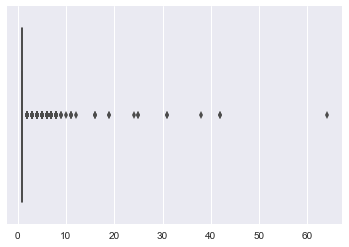

In [800]:
sns.boxplot(tdmatrix.sum())

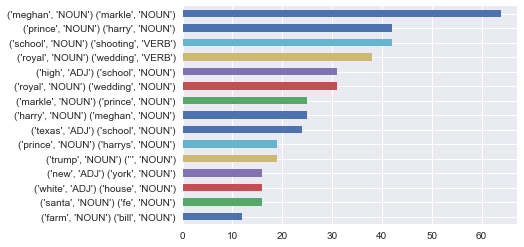

In [801]:
tdmatrix.sum().sort_values().tail(15).plot(kind='barh')

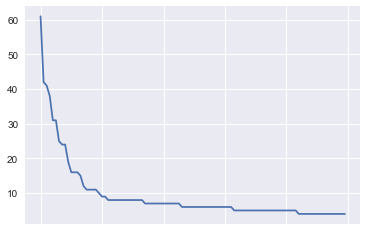

In [791]:
tdmatrix.sum().sort_values(ascending=False).head(100).plot(kind='line')

C:\Anaconda3\envs\media\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


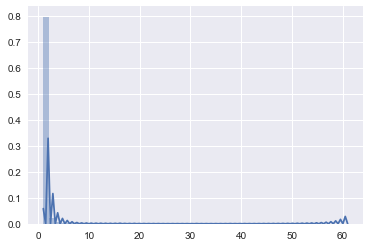

In [792]:
sns.distplot(tdmatrix.sum().sort_values())

***Dimensionality reduction:***

PCA:

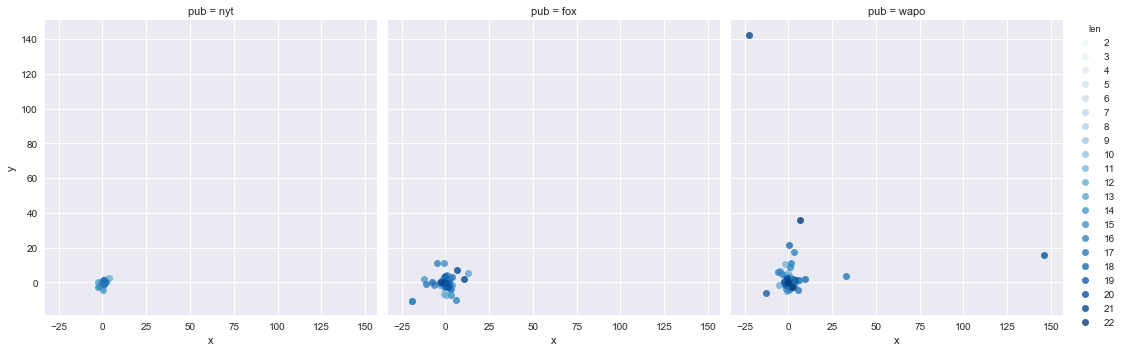

In [793]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(scaler.fit_transform(tdmatrix))
# pca_coords = pca.fit_transform(tdmatrix)

chartdata = pd.DataFrame(np.concatenate([pca_coords, headlines['pub'].values.reshape((len(headlines),1))], axis=1), index=headlines.index)
chartdata['len'] = headlines['text'].str.split().apply(len)
chartdata.loc[:, 0] = chartdata[0].astype(float)
chartdata.loc[:, 1] = chartdata[1].astype(float)

chartdata.columns = ['x', 'y', 'pub', 'len']

ax = sns.lmplot(data=chartdata, x='x',y='y', fit_reg=False, col='pub', hue='len', palette='Blues')

Isomap:

In [794]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=2)
coords = iso.fit_transform(tdmatrix)

chartdata = pd.DataFrame(np.concatenate([coords, headlines['pub'].values.reshape((1471,1))], axis=1), index=headlines.index)
chartdata['len'] = headlines['headline'].str.split().apply(len)
chartdata.loc[:, 0] = chartdata[0].astype(float)
chartdata.loc[:, 1] = chartdata[1].astype(float)

chartdata.columns = ['x', 'y', 'pub', 'len']

ax = sns.lmplot(data=chartdata, x='x',y='y', fit_reg=False, hue='len', col='pub', palette='Blues')
# ax.set(xlim=[-15,5], ylim=[-20,40])

ValueError: cannot reshape array of size 1751 into shape (1471,1)

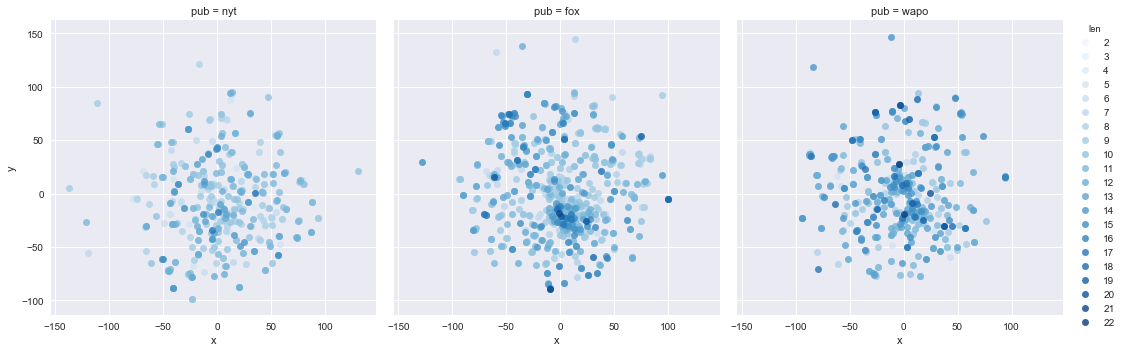

In [405]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5)
# scaler = StandardScaler(with_mean=True, with_std=True)
# tsne_coords = tsne.fit_transform(scaler.fit_transform(td))
tsne_coords = tsne.fit_transform(tdmatrix)

chartdata = pd.DataFrame(np.concatenate([tsne_coords, headlines['pub'].values.reshape((1471,1))], axis=1), index=headlines.index)
chartdata['len'] = headlines['headline'].str.split().apply(len)
chartdata.loc[:, 0] = chartdata[0].astype(float)
chartdata.loc[:, 1] = chartdata[1].astype(float)

chartdata.columns = ['x', 'y', 'pub', 'len']

ax = sns.lmplot(data=chartdata, x='x',y='y', fit_reg=False, hue='len', col='pub', palette='Blues')

parts of speech

In [110]:
import nltk
def pos_tag(doc):
    tokenized = nltk.word_tokenize(doc)
    tagged = nltk.pos_tag(tokenized)
    pos = [x[1] for x in tagged]
    return pd.Series(pos).value_counts()

pos_counts = headlines['headline'].apply(pos_tag).fillna(0)
pos_counts.head()

,#,$,'',(,),",",.,:,CC,CD,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WRB,``
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


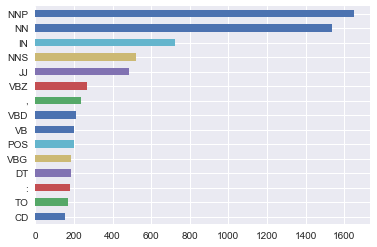

In [111]:
pos_counts.loc[headlines['pub']=='fox'].sum().sort_values().tail(15).plot(kind='barh')

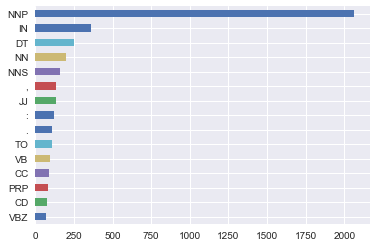

In [112]:
pos_counts.loc[headlines['pub']=='nyt'].sum().sort_values().tail(15).plot(kind='barh')

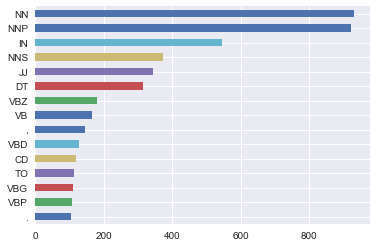

In [113]:
pos_counts.loc[headlines['pub']=='wapo'].sum().sort_values().tail(15).plot(kind='barh')

In [114]:
[x[1] for x in tagged]

NameError: name 'tagged' is not defined

In [262]:
nltk.pos_tag?

Signature: nltk.pos_tag(tokens, tagset=None, lang='eng')
Docstring:
Use NLTK's currently recommended part of speech tagger to
tag the given list of tokens.

    >>> from nltk.tag import pos_tag
    >>> from nltk.tokenize import word_tokenize
    >>> pos_tag(word_tokenize("John's big idea isn't all that bad."))
    [('John', 'NNP'), ("'s", 'POS'), ('big', 'JJ'), ('idea', 'NN'), ('is', 'VBZ'),
    ("n't", 'RB'), ('all', 'PDT'), ('that', 'DT'), ('bad', 'JJ'), ('.', '.')]
    >>> pos_tag(word_tokenize("John's big idea isn't all that bad."), tagset='universal')
    [('John', 'NOUN'), ("'s", 'PRT'), ('big', 'ADJ'), ('idea', 'NOUN'), ('is', 'VERB'),
    ("n't", 'ADV'), ('all', 'DET'), ('that', 'DET'), ('bad', 'ADJ'), ('.', '.')]

NB. Use `pos_tag_sents()` for efficient tagging of more than one sentence.

:param tokens: Sequence of tokens to be tagged
:type tokens: list(str)
:param tagset: the tagset to be used, e.g. universal, wsj, brown
:type tagset: str
:param lang: the ISO 639 code of the 